<a href="https://colab.research.google.com/github/keylos99/dtsc-2/blob/main/model_and_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving merged_state_coverage_data3 (2).xlsx to merged_state_coverage_data3 (2).xlsx


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Random Forest Test R^2: 0.7009
Random Forest Test RMSE: 1.6317


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-3-749f6046b201>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


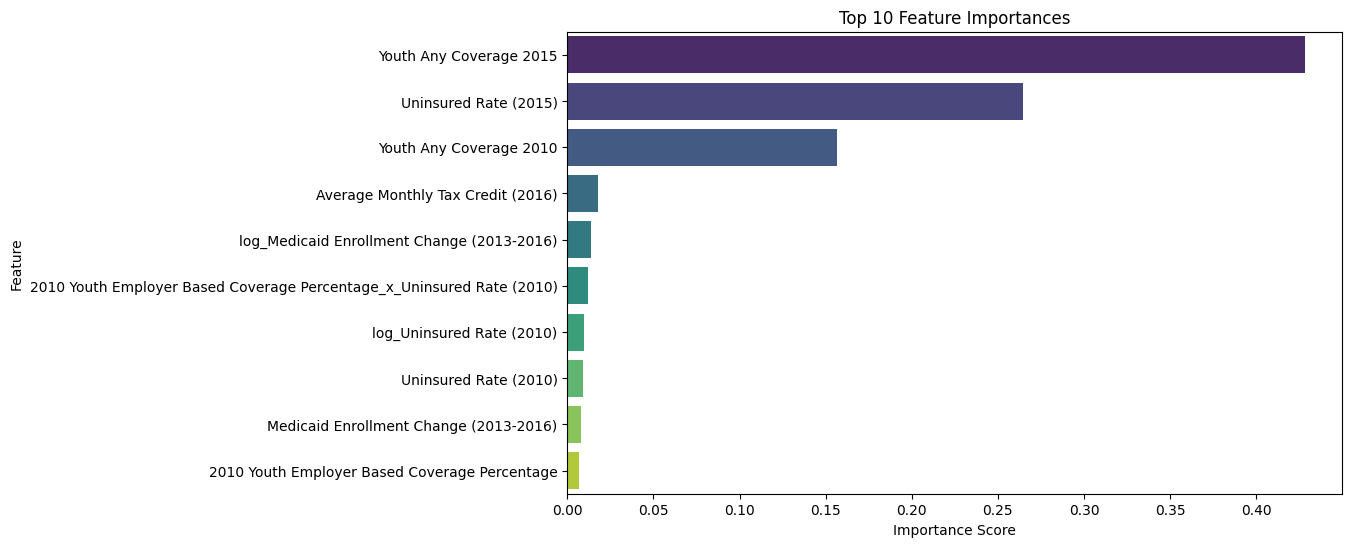

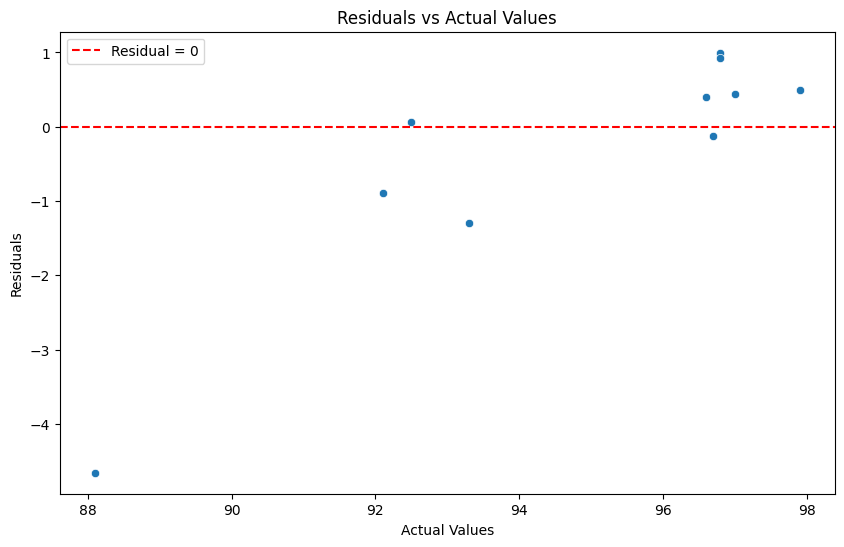

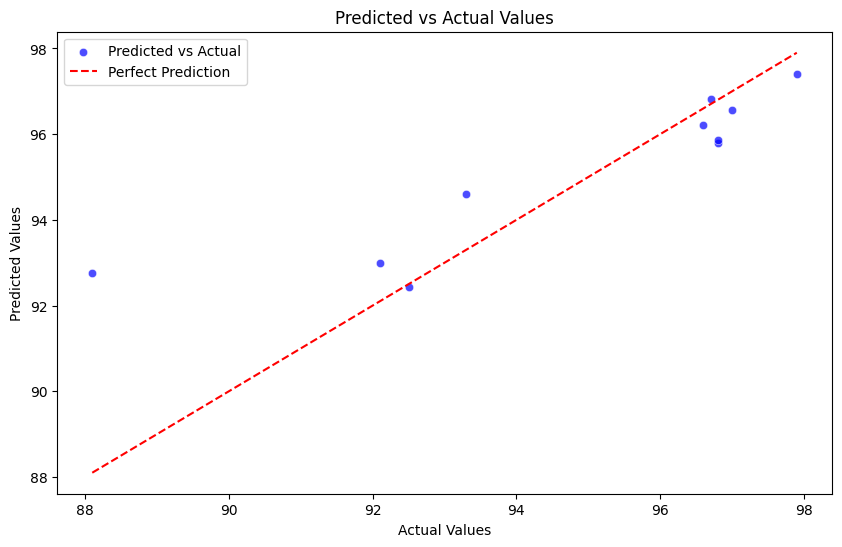

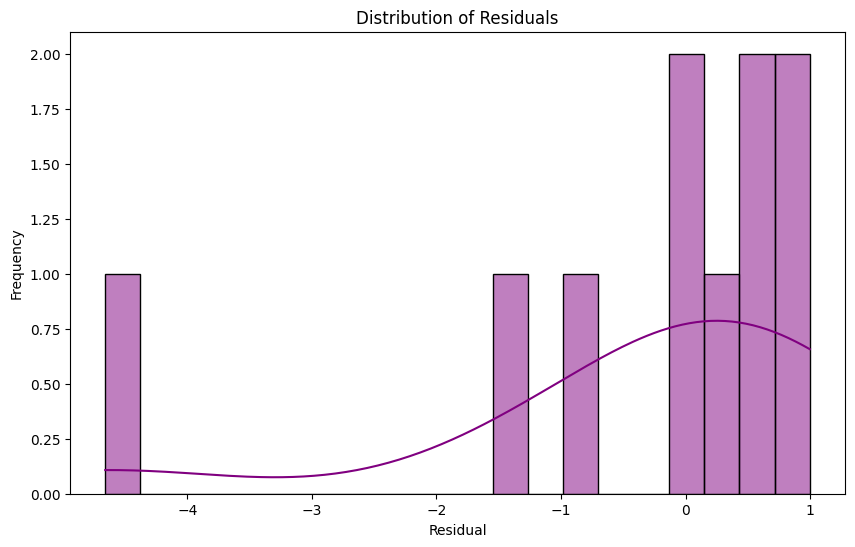

<ipython-input-3-749f6046b201>:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


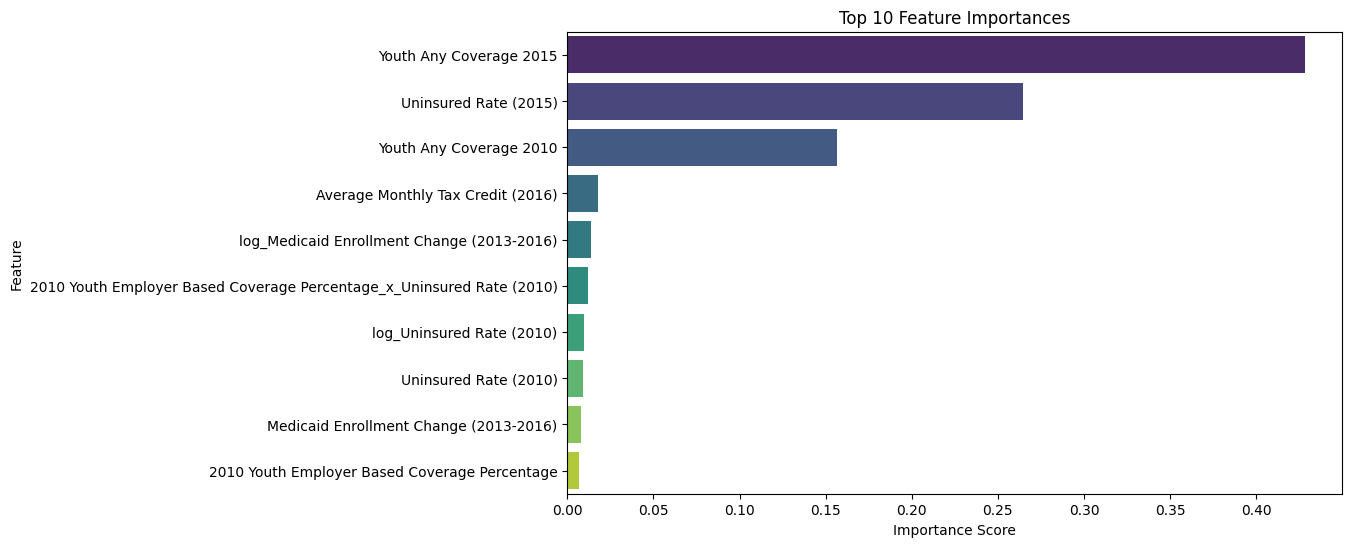

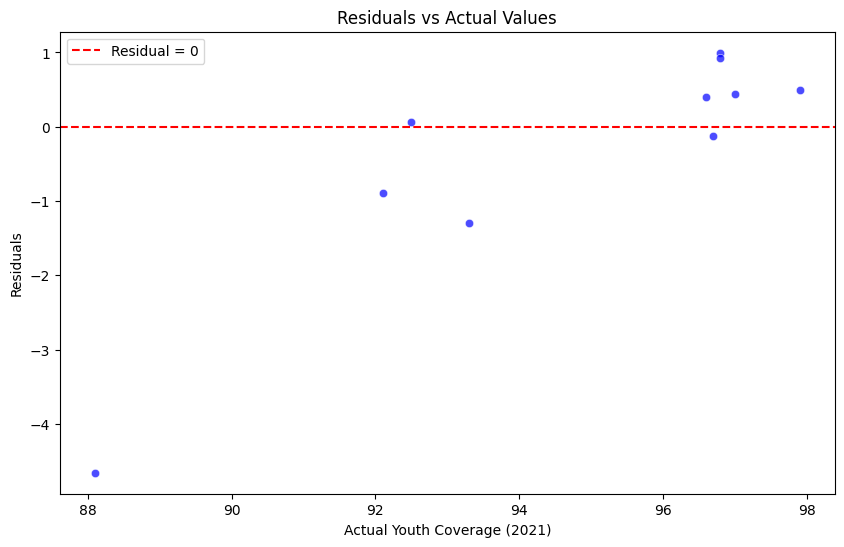

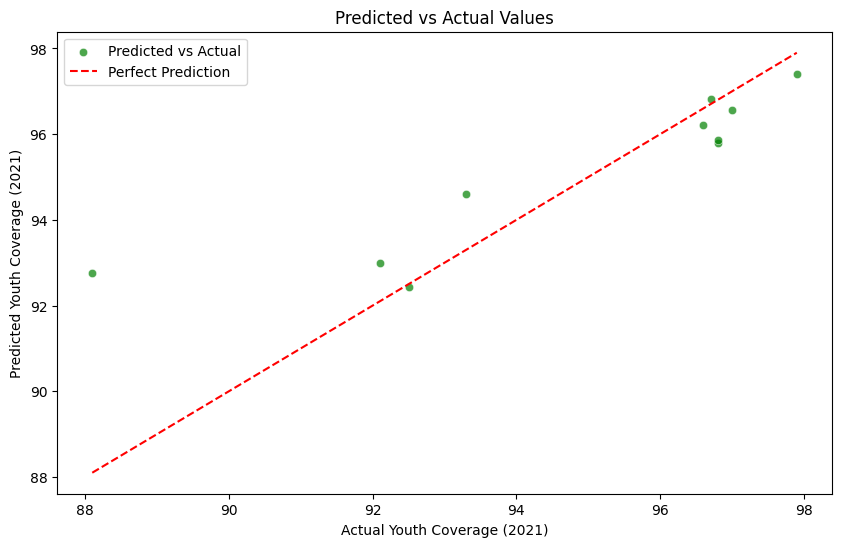

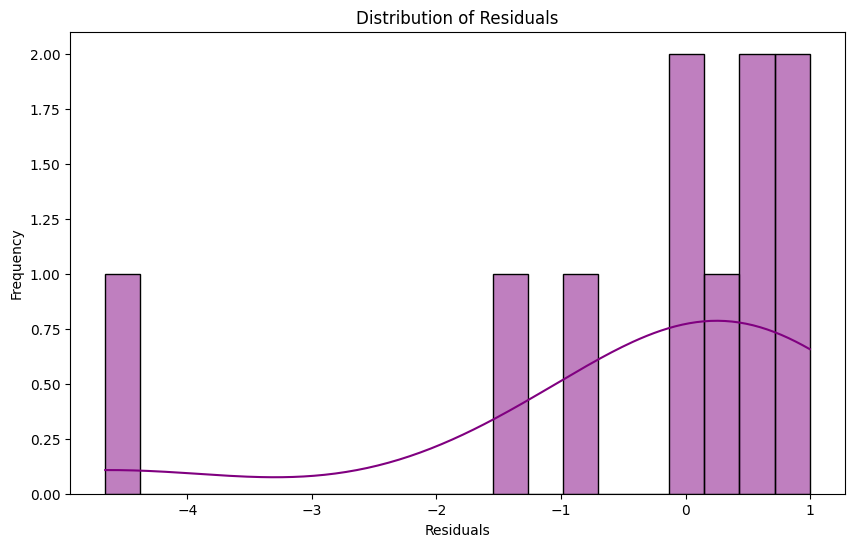

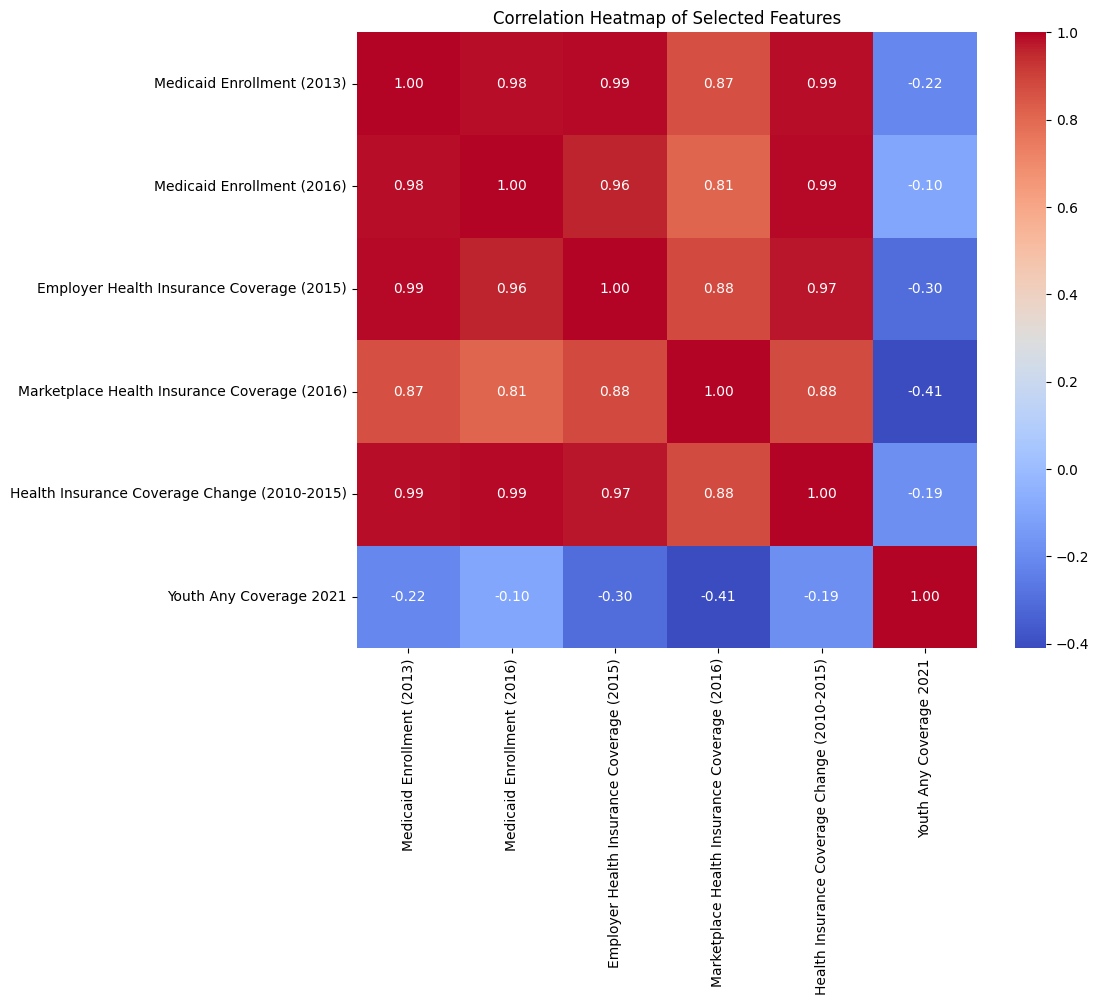

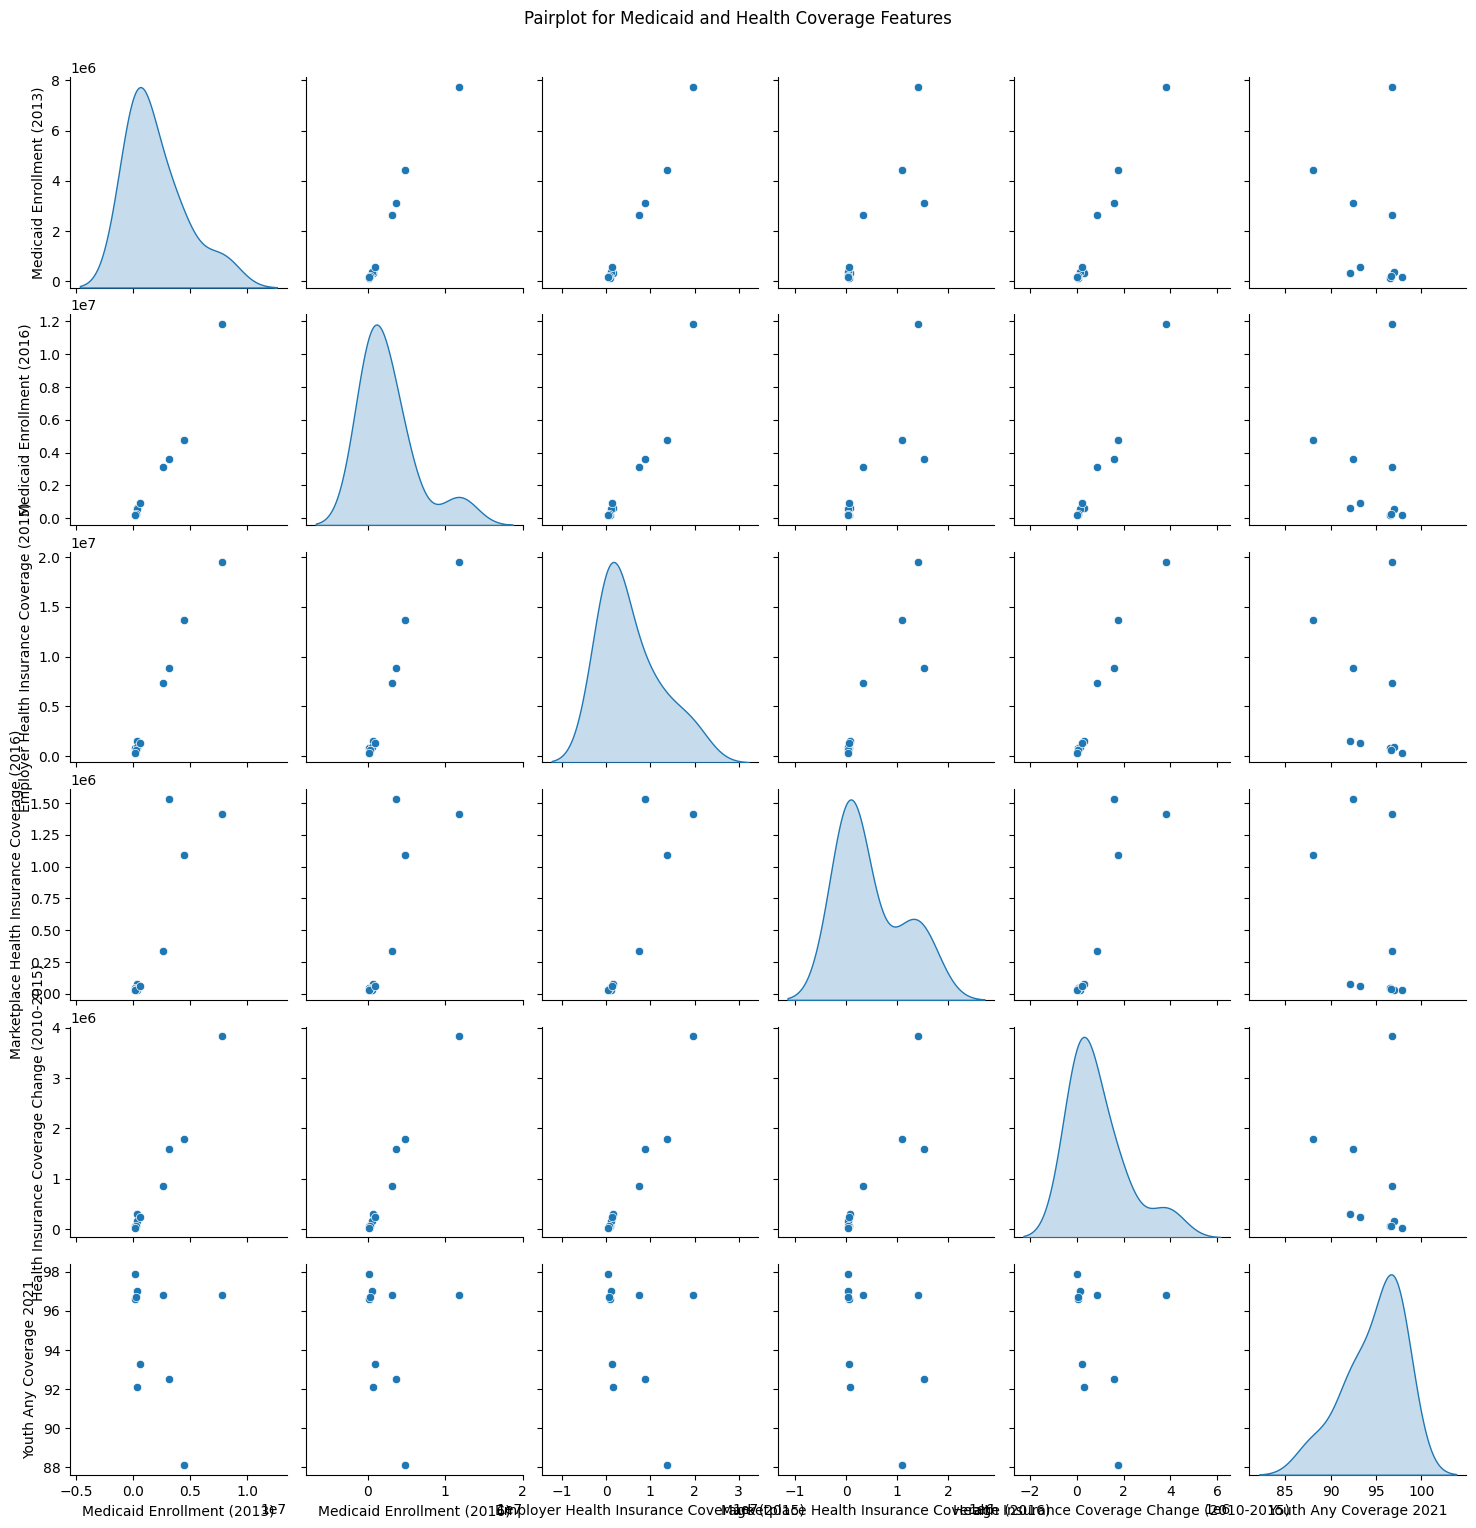

<ipython-input-3-749f6046b201>:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


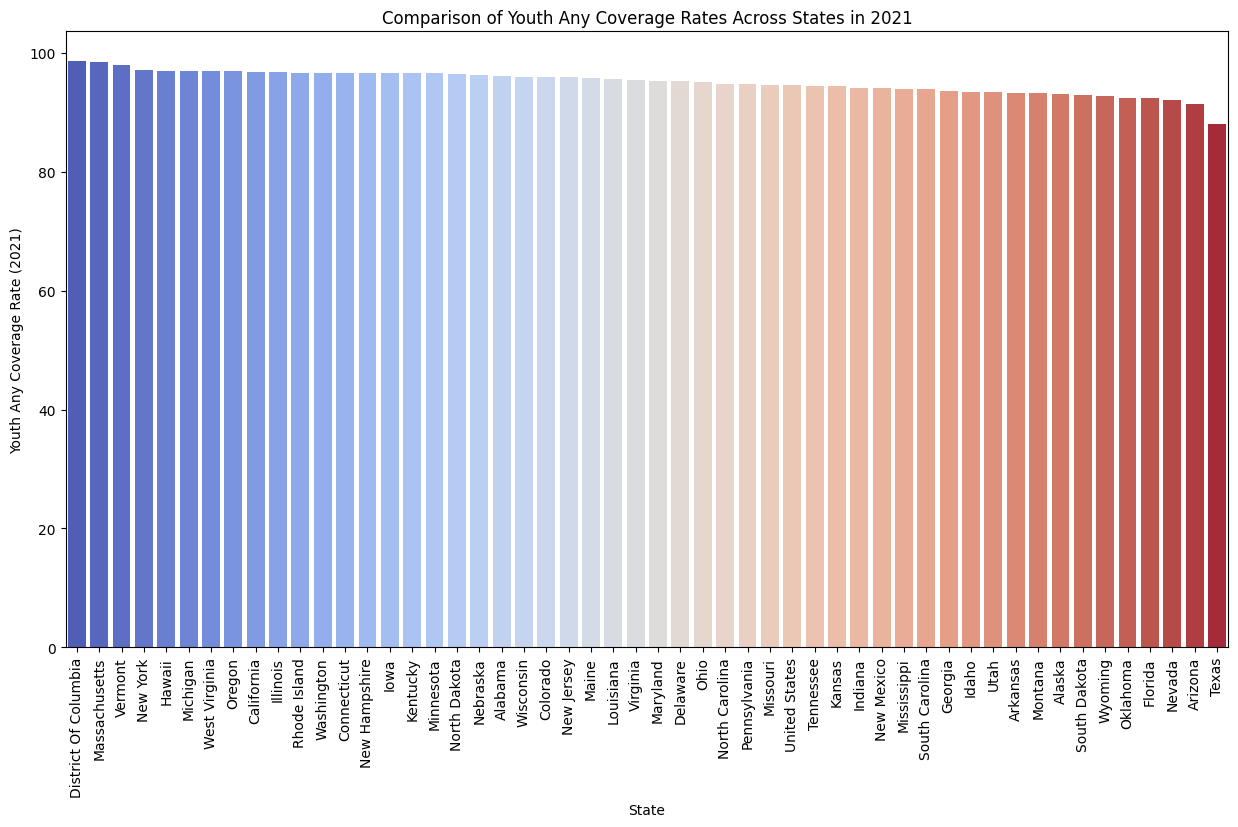

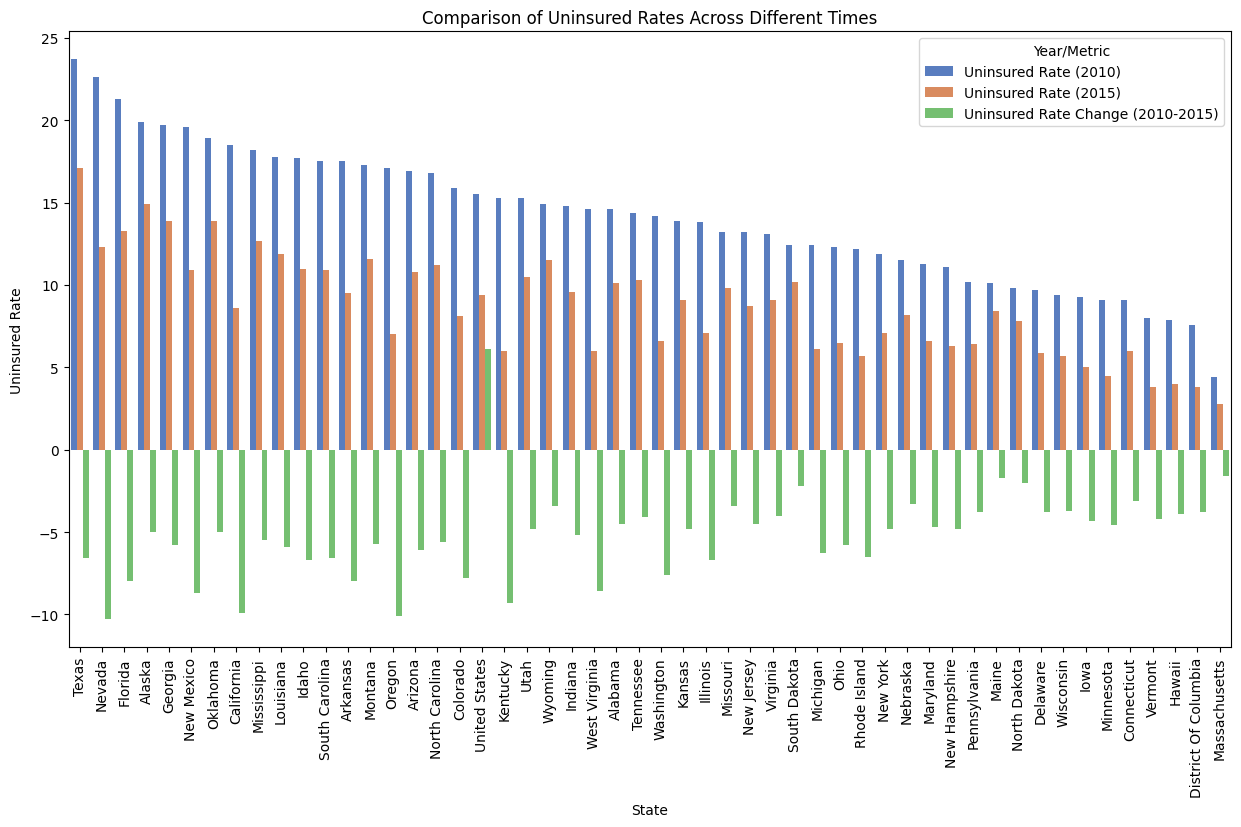

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
# Load the dataset
file_path = 'merged_state_coverage_data3 (2).xlsx'
data = pd.read_excel(file_path)

#function to clean numeric columns
def clean_numeric(column):
    return (
        column.replace('[\$,%,]', '', regex=True)  # Remove $, %, and other symbols
        .astype(float)  # Convert to float
    )

# List columns to clean
columns_to_clean = [
    '2010 Youth Employer Based Coverage Percentage',
    'Medicaid Enrollment Change (2013-2016)',
    'Marketplace Health Insurance Coverage (2016)',
    'Employer Health Insurance Coverage (2015)',
    'Uninsured Rate (2010)',
    'Uninsured Rate (2015)',
    'Uninsured Rate Change (2010-2015)',
    'Average Monthly Tax Credit (2016)'
]

# Apply cleaning to relevant columns
for col in columns_to_clean:
    data[col] = clean_numeric(data[col])

# Create a copy of the data for feature engineering
data_fe = data.copy()

# 1. Log Transformations
log_transform_vars = [
    '2010 Youth Employer Based Coverage Percentage',
    'Medicaid Enrollment Change (2013-2016)',
    'Marketplace Health Insurance Coverage (2016)',
    'Employer Health Insurance Coverage (2015)',
    'Uninsured Rate (2010)'
]
for var in log_transform_vars:
    data_fe[f'log_{var}'] = np.where(
        data_fe[var] > 0,  # Only positive values
        np.log(data_fe[var]),  # Apply log transformation
        np.nan  # Assign NaN for invalid values
    )

# 2. Interaction Terms
interaction_pairs = [
    ('2010 Youth Employer Based Coverage Percentage', 'Uninsured Rate (2010)'),
    ('Employer Health Insurance Coverage (2015)', 'Marketplace Health Insurance Coverage (2016)')
]
for var1, var2 in interaction_pairs:
    data_fe[f'{var1}_x_{var2}'] = data_fe[var1] * data_fe[var2]

# 3. Polynomial Terms
polynomial_vars = [
    '2010 Youth Employer Based Coverage Percentage',
    'Employer Health Insurance Coverage (2015)'
]
for var in polynomial_vars:
    data_fe[f'{var}^2'] = data_fe[var] ** 2
    data_fe[f'{var}^3'] = data_fe[var] ** 3

# Prepare data for modeling
# Select relevant independent variables
independent_vars = [col for col in data_fe.columns if col not in ['State', 'Youth Any Coverage 2021']]
X = data_fe[independent_vars].dropna()
y = data_fe['Youth Any Coverage 2021'].loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred = rf.predict(X_test)
print(f"Random Forest Test R^2: {r2_score(y_test, y_pred):.4f}")
print(f"Random Forest Test RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Feature Importance Plot
# Get feature importances from the model
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = X_train.columns[sorted_idx][:10]  # Top 10 features
top_importances = feature_importances[sorted_idx][:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# 2. Residual Plot
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--', label='Residual = 0')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 3. Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# 4. Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming the model and data are loaded as `rf`, `X_train`, `X_test`, `y_test`, and `y_pred`.

# 1. Feature Importance Plot
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]  # Sort in descending order
top_features = X_train.columns[sorted_idx][:10]  # Top 10 features
top_importances = feature_importances[sorted_idx][:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Residual = 0')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Youth Coverage (2021)')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 3. Predicted vs Actual Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='green', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Youth Coverage (2021)')
plt.ylabel('Predicted Youth Coverage (2021)')
plt.legend()
plt.show()

# 4. Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 5. Correlation Heatmap for Selected Features
selected_features = [
    "Medicaid Enrollment (2013)",
    "Medicaid Enrollment (2016)",
    "Employer Health Insurance Coverage (2015)",
    "Marketplace Health Insurance Coverage (2016)",
    "Health Insurance Coverage Change (2010-2015)"
]

# Ensure column names match exactly
actual_columns = X_train.columns.tolist()  # Get actual column names from the data
selected_features_corrected = [col for col in selected_features if col in actual_columns]

# Add Youth Any Coverage 2021 from y_test but ensure alignment
correlation_data = pd.concat([
    X_test[selected_features_corrected].reset_index(drop=True),  # Align selected features
    y_test.reset_index(drop=True)  # Add the dependent variable
], axis=1)

# Rename target variable for clarity
correlation_data.rename(columns={y_test.name: "Youth Any Coverage 2021"}, inplace=True)

# Generate correlation matrix
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

# 6. Pairplot for Key Relationships
sns.pairplot(correlation_data, kind="scatter", diag_kind="kde")
plt.suptitle("Pairplot for Medicaid and Health Coverage Features", y=1.02)
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(
    x='State',
    y='Youth Any Coverage 2021',
    data=data_fe.sort_values(by='Youth Any Coverage 2021', ascending=False),  # Corrected dataset
    palette='coolwarm'
)
plt.xticks(rotation=90)
plt.title('Comparison of Youth Any Coverage Rates Across States in 2021')
plt.xlabel('State')
plt.ylabel('Youth Any Coverage Rate (2021)')
plt.show()

uninsured_columns = ['Uninsured Rate (2010)', 'Uninsured Rate (2015)', 'Uninsured Rate Change (2010-2015)']
uninsured_data = data_fe[['State'] + uninsured_columns].melt(
    id_vars='State',
    var_name='Year/Metric',
    value_name='Uninsured Rate'
)

plt.figure(figsize=(15, 8))
sns.barplot(
    x='State',
    y='Uninsured Rate',
    hue='Year/Metric',
    data=uninsured_data.sort_values(by='Uninsured Rate', ascending=False),
    palette='muted'
)
plt.xticks(rotation=90)
plt.title('Comparison of Uninsured Rates Across Different Times')
plt.xlabel('State')
plt.ylabel('Uninsured Rate')
plt.legend(title='Year/Metric', loc='upper right')
plt.show()
